This notebook does EDA and engineers some new features using NLP tools.
The data from the two subreddit input files are combined and the new features are added in to the file data_cleaned.csv.

In [35]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag

from textblob import TextBlob

#### Display Settings

In [36]:
pd.set_option('max_colwidth', 200)

### Data Overview + Merging

In [37]:
poems = pd.read_csv('data/OCPoetry.csv', index_col = 0)
sss = pd.read_csv('data/shortscarystories.csv', index_col=0)

In [38]:
poems['subreddit'] = 'OCPoetry'
sss['subreddit'] = 'shortscarystories'

In [39]:
poems.head()

,title,text,auth,time,subreddit
0,the moths of time,the moths of time consume your image; everything of you is gone from my life.\nbut after all this time i still glimpse your grimace in a mirror that reflects when the world was rife.\n\n\nhand on ...,lizerdqweenchlo,1643240027,OCPoetry
1,Haunted Houses,Floorboards creak\n\nUnder little kid feet\n\nAs a new family arrives\n\nThat the siblings want to meet\n\n&amp;#x200B;\n\nA big sister!\n\nA big brother!\n\nA new father!\n\nAnd new mother!\n\n&a...,richardcrack,1643238939,OCPoetry
2,Forest of Eden,"&amp;#x200B;\n\nHe could never quite find\n\nWhat made it paradise. \n\nWas it the way needles fell \n\nFrom the shadeless pines, \n\n&amp;#x200B;\n\nOr the river that raised \n\nHis grandmothers’...",mgmgmgmgm,1643237039,OCPoetry
3,The deepest fluctuation of creativity,"With due regard at your behest\n\nI'll smear the ink and burn the rest,\n\na long and overdue repose\n\nwith words withheld and all books closed,\n\nI'll lie as silent as the grave\n\nand sleep in...",puredreadful,1643234027,OCPoetry
4,The deepest fluctuation of creativity,"With due regard at your behest\n\nI'll smear the ink and burn the rest,\n\na long and overdue repose\n\nwith words withheld and all books closed,\n\nI'll lie as silent as the grave\n\nand sleep in...",puredreadful,1643234027,OCPoetry


In [40]:
poems.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29905 entries, 0 to 48
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      29905 non-null  object
 1   text       29905 non-null  object
 2   auth       29905 non-null  object
 3   time       29905 non-null  int64 
 4   subreddit  29905 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.4+ MB


In [41]:
sss.head()

,title,text,auth,time,subreddit
0,Fruit of Human Kindness,"**Let it be stated, for the record, that what follows is the examination of one Conrad Marlow, in relation to allegations made against Mr Marlow's former employer, the anthropologist and sitting M...",normancrane,1643239674,shortscarystories
1,MEDICINE BALL,"\n\nMy boyfriend and I felt we were not getting exercise and outdoors enough during this bleak winter. Even before the pandemic neither of us were active enough, and with both working long hours...",eloquentursula,1643229661,shortscarystories
2,The Mandela Effect Is Real And I can Prove it.,\n\nDoes anybody remember the film The Lost Boys? It was my favourite film as a kid. I idolised the Frog Brothers and imagined myself fighting vampires side by side with them. I had an awesome p...,Roos85,1643220793,shortscarystories
3,The most weird call I had ever gotten as a babysitter. (Fictional),"Hi, Im Natalie, 24 year old babysitter, and I wanted to share one of my most bone chilling experiences with a costumer.\n\nIt was around 4am, I was deep asleep, snoring so loud it sounded like a ...",Riaxxxxxx_,1643220655,shortscarystories
4,Forever young,"They will tell you she killed herself.\n\nShe didn't. I saw what happened, I told and explained them.\n\nThey didn't believe me. Said that I need rest, that I was in denial, that my mind played tr...",Thunder-and-Dark,1643213868,shortscarystories


In [42]:
sss.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28687 entries, 0 to 93
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      28687 non-null  object
 1   text       28586 non-null  object
 2   auth       28687 non-null  object
 3   time       28687 non-null  int64 
 4   subreddit  28687 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.3+ MB


Merge the two subreddit data frames in to one.

In [43]:
df = pd.concat([poems, sss])
df.reset_index(drop=True, inplace=True)

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58592 entries, 0 to 58591
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      58592 non-null  object
 1   text       58491 non-null  object
 2   auth       58592 non-null  object
 3   time       58592 non-null  int64 
 4   subreddit  58592 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.2+ MB


### Data Cleaning

#### Fill empty strings

In [45]:
df['text'].fillna('', inplace=True)
df['title'].fillna('', inplace = True)

#### Count whitespace

Whitespace features could be predictive of poetry - I will count them here and then remove them from the text, so they can be included or not in later analysis.

In [46]:
df['new_line_chars'] = df['text'].str.count('\n')
df['tab_chars'] = df['text'].str.count('\t')
df['space_chars'] = df['text'].str.count(' ')
df['zws_chars'] = df['text'].str.count('#x200B') + df['text'].str.count('nbsp') # Zero width space characters

In [47]:
pd.DataFrame(df.loc[:, 'new_line_chars':'zws_chars'].mean(), columns = ['Avg per post'])

,Avg per post
new_line_chars,35.662445
tab_chars,0.041661
space_chars,249.282632
zws_chars,1.416832


#### Remove zero width spaces

Since we will use count vectorization in our models it is good to remove non-textual signals. In this case the zero width space sequence '&amp;#x200B;' appears more than 65,000 times in the data, especially in r/OCPoetry.

In [48]:
df['text'].str.count('&amp;#x200B;').sum()

65971

In [49]:
df['text'].str.count('#x200B').sum()

65993

In [50]:
df.query('subreddit == "OCPoetry"')['text'].str.count('&amp;#x200B;').sum()

52537

Alternate non breaking space encoding.

In [51]:
df['text'].str.count('nbsp').sum(), \
df['text'].str.count('&amp;nbsp;').sum(), \
df['text'].str.count('&amp;nbsp').sum()

(17022, 16806, 17011)

In [52]:
def remove_zws(text_col):
    text_col = text_col.str.replace('&amp;#x200B;', '')
    text_col = text_col.str.replace('&amp;nbsp;', '')
    text_col = text_col.str.replace('&amp;nbsp', '')
    return text_col

In [53]:
df['text'] = remove_zws(df['text'])
df['title'] = remove_zws(df['title'])

#### Filter URLs

URLs are difficult to do NLP on and they are also far more common in the OCPoetry subreddit which biases our models. To fix this we should remove them from the text column.

In [54]:
df.loc[23854, 'text'] # Example post with 2 urls

'\nwrite songs for my poems\nput method to my madness\nplease deaden my mind\n\n[1](https://www.reddit.com/r/OCPoetry/comments/ir71un/lusts_smile/?utm_source=share&amp;utm_medium=ios_app&amp;utm_name=iossmf)\n\n[2](https://www.reddit.com/r/OCPoetry/comments/ipgn9o/a_dream_i_once_had/?utm_source=share&amp;utm_medium=ios_app&amp;utm_name=iossmf)'

In [55]:
df.loc[23854, 'text'].split()

['write',
 'songs',
 'for',
 'my',
 'poems',
 'put',
 'method',
 'to',
 'my',
 'madness',
 'please',
 'deaden',
 'my',
 'mind',
 '[1](https://www.reddit.com/r/OCPoetry/comments/ir71un/lusts_smile/?utm_source=share&amp;utm_medium=ios_app&amp;utm_name=iossmf)',
 '[2](https://www.reddit.com/r/OCPoetry/comments/ipgn9o/a_dream_i_once_had/?utm_source=share&amp;utm_medium=ios_app&amp;utm_name=iossmf)']

In this example the last two tokens return a nonnegative number from `find('https')` indicating they contain a url. The urls are removed with the following cell.

In [56]:
[token.find('https') for token in df.loc[23854, 'text'].split()]

[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 4, 4]

In [57]:
' '.join([token for token in df.loc[23854, 'text'].split() if token.find('https') == -1])

'write songs for my poems put method to my madness please deaden my mind'

Function to remove all urls from the text field.
Note this has the side effect of removing all other white space. 

In [58]:
def scrub_url(text):
    return ' '.join([token for token in text.split() if token.find('https') == -1])

In [59]:
df['text'] = [scrub_url(text) for text in df['text']]
df['title'] = [scrub_url(text) for text in df['title']]

In [60]:
df['text'].str.count('https').sum() # check scrubbing

0

In [61]:
df['title'].str.count('https').sum()

0

#### Parse dates

In [62]:
df['time'] = pd.to_datetime(df['time'], unit = 's')

#### New feature: word counts

In [63]:
df['title_words'] = df['title'].str.split().str.len()

In [64]:
df['title_words'].value_counts().head()

2    13347
1    11030
3    10396
4     7508
5     5599
Name: title_words, dtype: int64

In [65]:
df.sort_values(by = 'title_words', ascending=False).head() # There are some very long titles.

,title,text,auth,time,subreddit,new_line_chars,tab_chars,space_chars,zws_chars,title_words
38464,I just want to die i cant live in this house with them anymore just because i don’t want to leave my room she got 7 other CHILD why does it have to be me why do i have to do the chores why does sh...,Please if they didnt they then i wish i will,S9_b10,2021-01-30 18:25:28,shortscarystories,0,0,9,0,63
38213,"Hola , personas de Reddit el otro día recordé una película que ví hace muchos años que tenía un corto asiático de terror acerca de un chico que hace un ritual y acaba en otra dimensión muy bizarra...",,Key-frank-3678,2021-02-14 18:10:50,shortscarystories,0,0,0,0,60
30893,I heard this of this short story about a man who spends his night asking a girl who comes out her door and she feels forced into doing it by this guy verbally abusing her outside her door. She eve...,,carlpoppa618II,2021-12-16 01:09:51,shortscarystories,0,0,0,0,60
20427,"Title: COVID-19. I wrote this a little while back, and have just found this sub reddit. Idk the culture here, so this is gonna be just how I write and recite. I try to break it in ways that can be...",Front lines have become local And we got new soldiers In scrubs and white coats and They trying to save the lives of the people Still low on the PPE for the professionals How come THEY have it una...,chill-_-monkey,2020-11-29 04:42:07,OCPoetry,26,0,97,0,59
26821,"Hello. I'm Santimental, but you can call me just San. I'm usually a story writer, but still a storyteller. I found some muse for writing, and defining it as my poetry was the closest way for me to...","My meaning? Soul. Not purpose. Meaning. The thing, striving after which things make just that bit more sense. It satisfies that itch for something that doesn't exist. How do you make meaning, soul...",Santimental,2020-07-02 08:10:42,OCPoetry,4,0,486,0,59


In [66]:
df['text_words'] = df['text'].str.split().str.len()
# df.sort_values(by = 'text_words', ascending=False).head()

In [67]:
df['word_count'] = df['title_words'] + df['text_words']

Additionally the previous whitespace features should be normalized by the word count to show the white space density. The +1 in the denominator is to avoid division by zero.

In [68]:
df.loc[:, 'new_line_chars':'zws_chars'] = df.loc[:, 'new_line_chars':'zws_chars'].div(df['text_words'] + 1, axis = 0).fillna(0)

#### Remove posts with minimal content

In [69]:
df.query('text_words == 1')

,title,text,auth,time,subreddit,new_line_chars,tab_chars,space_chars,zws_chars,title_words,text_words,word_count
71,Cheeks,[deleted],[deleted],2022-01-25 14:51:36,OCPoetry,0.0,0.0,0.0,0.0,1,1,2
335,TEST,TEST,ParadiseEngineer,2022-01-19 19:32:41,OCPoetry,0.0,0.0,0.0,0.0,1,1,2
847,Reflection in water,[deleted],[deleted],2022-01-09 15:15:01,OCPoetry,0.0,0.0,0.0,0.0,3,1,4
1246,"New year, new me?",[deleted],[deleted],2022-01-01 00:29:50,OCPoetry,0.0,0.0,0.0,0.0,4,1,5
1283,A Man With A Gun In The Closet,[deleted],[deleted],2021-12-31 01:28:38,OCPoetry,0.0,0.0,0.0,0.0,8,1,9
...,...,...,...,...,...,...,...,...,...,...,...,...
57279,I am not Suicidal,[deleted],[deleted],2018-08-10 12:48:13,shortscarystories,0.0,0.0,0.0,0.0,4,1,5
57280,Overthinking,[deleted],[deleted],2018-08-10 07:40:30,shortscarystories,0.0,0.0,0.0,0.0,1,1,2
57316,Happy Birthday Hannah,\[removed\],Ghettoceratops,2018-08-08 17:35:25,shortscarystories,0.0,0.0,0.0,0.0,3,1,4
57318,Carolines Notebooks,\[removed\],minroe-mafdet,2018-08-08 17:08:51,shortscarystories,0.0,0.0,0.0,0.0,2,1,3


1016 posts are marked as deleted - I will drop these from the data set.

In [70]:
df.query('text == "[deleted]"')

,title,text,auth,time,subreddit,new_line_chars,tab_chars,space_chars,zws_chars,title_words,text_words,word_count
71,Cheeks,[deleted],[deleted],2022-01-25 14:51:36,OCPoetry,0.0,0.0,0.0,0.0,1,1,2
847,Reflection in water,[deleted],[deleted],2022-01-09 15:15:01,OCPoetry,0.0,0.0,0.0,0.0,3,1,4
1246,"New year, new me?",[deleted],[deleted],2022-01-01 00:29:50,OCPoetry,0.0,0.0,0.0,0.0,4,1,5
1283,A Man With A Gun In The Closet,[deleted],[deleted],2021-12-31 01:28:38,OCPoetry,0.0,0.0,0.0,0.0,8,1,9
1358,Sehar,[deleted],[deleted],2021-12-29 13:21:22,OCPoetry,0.0,0.0,0.0,0.0,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...
57267,Failure.,[deleted],[deleted],2018-08-10 21:53:17,shortscarystories,0.0,0.0,0.0,0.0,1,1,2
57268,Adventurous spirits,[deleted],[deleted],2018-08-10 20:20:55,shortscarystories,0.0,0.0,0.0,0.0,2,1,3
57275,Next Level,[deleted],[deleted],2018-08-10 14:06:49,shortscarystories,0.0,0.0,0.0,0.0,2,1,3
57279,I am not Suicidal,[deleted],[deleted],2018-08-10 12:48:13,shortscarystories,0.0,0.0,0.0,0.0,4,1,5


In [71]:
df.query('text != "[deleted]"', inplace = True)

##### Other short posts

In [72]:
df.query('text_words <= 5').sample(10)

,title,text,auth,time,subreddit,new_line_chars,tab_chars,space_chars,zws_chars,title_words,text_words,word_count
52654,Found A Cool Video Of Scary Stories On Reddit!,pretty scary stuff,MichalWilk17,2019-06-12 21:30:37,shortscarystories,0.5,0.0,0.500000,0.0,9,3,12
18305,“Where Do We Go?” [@onealexvon],,onealexvon,2021-01-04 21:33:00,OCPoetry,0.0,0.0,1.000000,0.0,5,0,5
36736,"At the most common people we last to say about to say, that the line ghost wasn't there. This contry are most chili 42424w14q1eydgydgfygcdtr",,Google_Memes_For_All,2021-05-05 23:02:00,shortscarystories,0.0,0.0,0.000000,0.0,24,0,24
50903,The scariest of stories,My life,SamCat_011,2019-09-18 22:52:14,shortscarystories,0.0,0.0,0.333333,0.0,4,2,6
56045,FUCK,FUCK,I_ONLY_COMMENT_FUCK,2018-10-31 14:26:13,shortscarystories,9.0,0.0,0.000000,0.0,1,1,2
48256,super scary dont read,BOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO,illegalmidget,2020-01-29 17:31:33,shortscarystories,0.0,0.0,0.500000,0.0,4,1,5
54286,The Legend of Akashaa,,WekiTheDragon13,2019-02-25 07:17:51,shortscarystories,0.0,0.0,0.000000,0.0,4,0,4
40651,Creepy Story Of a depressed girl,,gezelex,2020-11-14 15:08:02,shortscarystories,0.0,0.0,0.000000,0.0,6,0,6
22823,Big Furry Monster Hands,,phriendlysciguy,2020-10-08 19:16:48,OCPoetry,0.0,0.0,0.000000,0.0,4,0,4
29699,Depressed,,RamenRamen1,2020-04-20 19:03:50,OCPoetry,0.0,0.0,0.000000,0.0,1,0,1


Posts with few words often are test posts or are primarily discussing a deleted link. 
Since it is hard to write a genuine poem or story in such few words and it is also difficult for an NLP model to analyze posts I will remove them from the data set.
While the threshold for number of words is some what arbitrary, it seems like posts with 5 or fewer owrds are rarely genuiune so in honor of [Ernest Hemingway](https://www.openculture.com/2015/03/the-urban-legend-of-ernest-hemingways-six-word-story.html) I will set the cutoff at 6 words in the text and title combined.

In [73]:
df.query('word_count <= 5').sample(10)

,title,text,auth,time,subreddit,new_line_chars,tab_chars,space_chars,zws_chars,title_words,text_words,word_count
29699,Depressed,,RamenRamen1,2020-04-20 19:03:50,OCPoetry,0.0,0.0,0.000000,0.0,1,0,1
38089,Furieux,Furieux http://gamahucherpress.yellowgum.com/wp-content/uploads/Furieux.pdf or,qiling,2021-02-21 01:16:27,shortscarystories,1.5,0.0,0.000000,0.0,1,3,4
34787,INVESTIGATING THE DEMON CHURCH,,nightmarereststop,2021-07-19 17:18:02,shortscarystories,0.0,0.0,0.000000,0.0,4,0,4
10610,Steer queen,,JJillusioniST,2021-06-03 15:21:09,OCPoetry,0.0,0.0,0.000000,0.0,2,0,2
15467,white room (LSD),[white,rq9xt,2021-02-19 10:58:17,OCPoetry,2.5,0.0,0.500000,0.0,3,1,4
48217,Horror story,Any one ?,il0vem0ney,2020-01-31 19:38:12,shortscarystories,0.0,0.0,0.500000,0.0,2,3,5
54286,The Legend of Akashaa,,WekiTheDragon13,2019-02-25 07:17:51,shortscarystories,0.0,0.0,0.000000,0.0,4,0,4
34582,THIS LOCATION IS CURSED,,nightmarereststop,2021-07-26 17:18:36,shortscarystories,0.0,0.0,0.000000,0.0,4,0,4
23577,test,test,PseudoangelGabriel,2020-09-18 21:12:06,OCPoetry,2.0,0.0,0.000000,0.0,1,1,2
56193,Grimm's War!,Check this,Grimmswaeoffical,2018-10-21 17:11:43,shortscarystories,0.0,0.0,0.666667,0.0,2,2,4


The 180 posts between 6 and 10 words have some spam but a majority seem to be legitimate poems / stories.

In [74]:
df.query('word_count <= 10 and word_count > 5').shape

(185, 12)

In [75]:
df.query('word_count <= 10 and word_count > 5').sample(10)

,title,text,auth,time,subreddit,new_line_chars,tab_chars,space_chars,zws_chars,title_words,text_words,word_count
20179,Simple Haiku,Oreos and milk Ebony and ivory Simple perfection,tbullionaire,2020-12-04 03:28:59,OCPoetry,0.222222,0.0,0.555556,0.000,2,8,10
9006,Goat Tower,"Anassemblage manbuilt; inevitable hierarchy— up, goats loft.",beumuth,2021-07-06 06:06:14,OCPoetry,0.750000,0.0,1.875000,7.875,2,7,9
36910,Burma (now Myanmar) folkore,Me and YOUR MOM.,Carrotstorrac,2021-04-29 04:04:03,shortscarystories,0.000000,0.0,0.600000,0.000,4,4,8
52141,Case of the Yerm-Chilays,With occasional oom!-stickits. I am hungover.,dmarti21,2019-07-13 08:54:58,shortscarystories,0.000000,0.0,0.714286,0.000,4,6,10
31216,The post said. Selling kids’ shoes.,Not worn.,imthemoney228,2021-12-01 20:56:29,shortscarystories,0.000000,0.0,0.333333,0.000,6,2,8
25403,Deadline,Life only has one time limit.,MikeGelato,2020-08-06 06:38:07,OCPoetry,0.571429,0.0,0.714286,0.000,1,6,7
25474,To anyone that ever calls you too emotional,,Raystee,2020-08-04 18:42:45,OCPoetry,0.000000,0.0,0.000000,0.000,8,0,8
29328,"Not a poem, but a request for ideas please",,lovestruck-bottom,2020-05-01 00:01:39,OCPoetry,0.000000,0.0,0.000000,0.000,9,0,9
3158,Death | An Original Poem,Death | An Original Poem,k_e_francis,2021-11-19 16:43:13,OCPoetry,0.333333,0.0,0.833333,0.000,5,5,10
20792,Pressure hit last us all in different ways,[pressure cooker,Smoothvibes32,2020-11-22 02:13:41,OCPoetry,0.000000,0.0,0.666667,0.000,8,2,10


In [76]:
df.query('word_count >= 6', inplace = True)

#### Check for duplicates

I'll drop all the duplicate entries.

In [77]:
df.duplicated(subset = ['text', 'title', 'subreddit']).sum()

835

In [78]:
df.drop_duplicates(subset = ['text', 'title', 'subreddit'], inplace=True)

### Additional feature engineering

In [79]:
df['title_text'] = df['title'] + df['text']

In addition to vectorizing the bag of words (with either a count or tfidf vectorizer) we look at 3 additional features:
* whitespace - already defined in the Data Cleaning section
* part of speech frequency
* sentiment scores (polarity and subjcetivity)

#### Part of speech tagging

This categorizes each word by it's part of speech. This let's us compare if certain word types or tenses are used more or less in each subreddit.
It also categorizes punctuation.

Part of speech tagging is down using the NLTK library and uses the Penn Treebank tagset by default.

In [80]:
# # Downloads needed for pos_extractor
# nltk.download('averaged_perceptron_tagger')
# nltk.download('tagsets')

In [81]:
tagset = ['CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNS',
          'NNP', 'NNPS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM',
          'TO','UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB',
          '.', ',', ':', '(', ')', '$', '``', '#', "''"]

def pos_extractor(docs):
    tag_counts = {pos: np.zeros(len(docs)) for pos in tagset}
    for i, doc in enumerate(docs):
        if not i % 1000:
            print(i)
        doc_tokens = word_tokenize(doc)
        pos_list = list(zip(*pos_tag(doc_tokens)))[1]
        for pos in pos_list:
            tag_counts[pos][i] += 1

    return pd.DataFrame(tag_counts)

Compute the part of speech counts. We also normalize the parts of speech by word count. The rows won't exactly sum to 1 as they include punctuation.

In [82]:
df_pos = pos_extractor(df['title_text'])
df_pos = df_pos.divide(df.reset_index()['word_count'] + 1, axis = 0)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000


In [83]:
df_pos.head()

,CC,CD,DT,EX,FW,IN,JJ,JJR,JJS,LS,...,WRB,.,",",:,(,),$,``,#,''
0,0.034965,0.000000,0.090909,0.013986,0.0,0.139860,0.069930,0.000000,0.000000,0.0,...,0.020979,0.069930,0.034965,0.013986,0.0,0.0,0.0,0.0,0.0,0.0
1,0.037500,0.006250,0.121875,0.003125,0.0,0.078125,0.096875,0.000000,0.000000,0.0,...,0.009375,0.012500,0.078125,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.064103,0.000000,0.141026,0.000000,0.0,0.089744,0.012821,0.000000,0.000000,0.0,...,0.000000,0.064103,0.089744,0.012821,0.0,0.0,0.0,0.0,0.0,0.0
3,0.086957,0.000000,0.130435,0.000000,0.0,0.108696,0.086957,0.000000,0.043478,0.0,...,0.000000,0.021739,0.043478,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.046921,0.032258,0.102639,0.000000,0.0,0.105572,0.052786,0.005865,0.002933,0.0,...,0.008798,0.049853,0.041056,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


#### Sentiment analysis

In [84]:
sentiment_cols = ['polarity', 'subjectivity']

def sentiment_extractor(docs):
    sentiments = {col: np.empty(len(docs)) for col in sentiment_cols}
    for i, doc in enumerate(docs):
        if not i % 1000:
            print(i)
        blob = TextBlob(doc)
        sentiments['polarity'][i] = blob.polarity
        sentiments['subjectivity'][i] = blob.subjectivity

    return pd.DataFrame(sentiments)

df_sentiments = sentiment_extractor(df['title_text'])

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000


### Merge features

`df_nlp` is the original data frame merged with nlp features.

In [85]:
df.shape, df_sentiments.shape, df_pos.shape

((56550, 13), (56550, 2), (56550, 45))

In [86]:
df.reset_index(inplace = True, drop = True)
df_nlp = df.join(df_pos)
df_nlp = df_nlp.join(df_sentiments)
df_nlp.shape

(56550, 60)

In [87]:
df_nlp.isna().sum().sum()

0

### EDA

The subreddits are nearly balanced.

In [88]:
df_nlp['subreddit'].value_counts()

OCPoetry             28616
shortscarystories    27934
Name: subreddit, dtype: int64

In [89]:
df_nlp['subreddit'].value_counts(normalize = True)

OCPoetry             0.50603
shortscarystories    0.49397
Name: subreddit, dtype: float64

#### Authors

Top 10 authors.

In [90]:
df_nlp['auth'].value_counts().head(10)

shortstory1            832
asearchforyou          548
EvantheNerd83          257
tim0777                250
hyperobscura           223
SimbaTheSavage8        166
sugar-soad             159
picnic-123             156
decorativegentleman    141
Hack_Shuck             138
Name: auth, dtype: int64

13853 users have only a single post

In [91]:
df['auth'].value_counts().value_counts().head(10) 

1     13942
2      3414
3      1412
4       828
5       482
6       302
7       230
8       158
9       117
10       90
Name: auth, dtype: int64

In [124]:
# sns.histplot(data = df['auth'].value_counts(), log_scale = 10)

#### Date overview

Something to be aware of is that the poetry subreddit is more active than the shortscarystories one. 
Therefore, in order to get a balanced data set the poetry posts are on average newer than the scary story posts.
Even though the final models won't use post date directly, to the extent that the posts reference contemporary events / figures our models may be learning these references rather than the differences between the mediums.
Alternatively, I could have collected data over a specified range (for example the year 2021), but then I would be left with an imbalanced data set.

In [93]:
def range_(x): 
    return x.max() - x.min()
df_nlp[['time', 'subreddit']].groupby('subreddit').agg([min, np.mean, range_])

time                                \
                                  min                          mean   
subreddit                                                             
OCPoetry          2020-04-16 00:37:44 2021-03-13 02:04:50.454640896   
shortscarystories 2018-05-07 08:13:08 2020-06-01 11:50:06.781055232   

                                      
                              range_  
subreddit                             
OCPoetry           650 days 22:56:03  
shortscarystories 1360 days 15:14:46

The r/OCPoetry subreddit seems to have a stable popularity while r/shortscarystories became more popular over time.

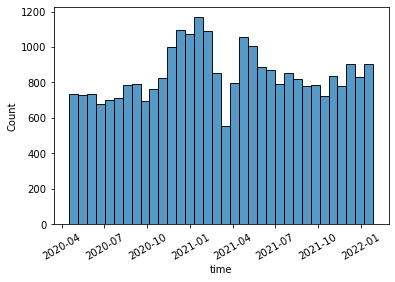

In [94]:
sns.histplot(x = 'time', data = df.query('subreddit == "OCPoetry"'))
plt.xticks(rotation = 30)
plt.show()

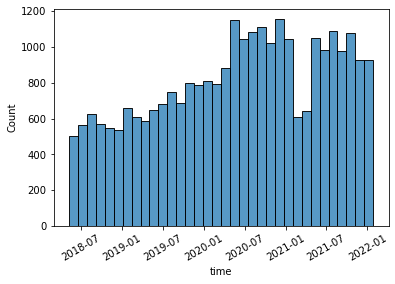

In [95]:
sns.histplot(x = 'time', data = df.query('subreddit == "shortscarystories"'))
plt.xticks(rotation = 30)
plt.show()

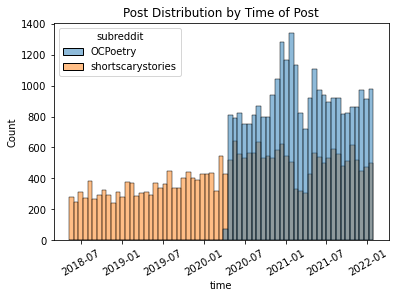

In [96]:
sns.histplot(x = 'time', data = df, hue = 'subreddit')
plt.title('Post Distribution by Time of Post')
plt.xticks(rotation = 30)
plt.show()

#### Word count comparison

The main difference in word length is that the text of posts on r/shortscarystories are more than twice as long as r/OCPoetry.
Additionally, r/shortscarystories posts have titles that are on average 0.5 word longer.

In [97]:
word_count_comp = df_nlp.groupby('subreddit')[['title_words', 'text_words', 'word_count']].mean()
word_count_comp

,title_words,text_words,word_count
subreddit,,,
OCPoetry,3.564474,152.808359,156.372833
shortscarystories,4.068268,369.090284,373.158552


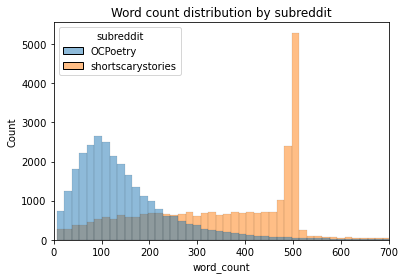

In [130]:
sns.histplot(x = 'word_count', hue = 'subreddit', data = df_nlp)
plt.xlim(0, 700)
plt.title('Word count distribution by subreddit')
plt.show()

#### Whitespace comparison

In [98]:
df_nlp['space_chars'].max()

31.727272727272727

This poem apparently has 31 spaces per word in it's original form.

In [99]:
df_nlp.iloc[df_nlp['space_chars'].argmax()]['text']

'for someone claiming to be so quiet I live quite the boisterous life I spend my days looking at many different squares luminous with many different things moving across their surface everything in this world and everything beyond and when I step outside the balmy summer air yanks me by my hair to a sudden halt making me stumble and leaving me dizzy [feedback [feedback'

In [100]:
df_nlp.iloc[df_nlp['space_chars'].argmax()]['subreddit']

'OCPoetry'

Average white space comparison. Except for spaces, all white space features are more common in r/OCPoetry than r/shortscarystories. This makes sense as poetry typically uses white space more creatively than prose.

In [101]:
df_nlp.groupby('subreddit')[['new_line_chars', 'tab_chars', 'space_chars', 'zws_chars']].mean()

,new_line_chars,tab_chars,space_chars,zws_chars
subreddit,,,,
OCPoetry,0.363811,0.000250,0.964865,0.018664
shortscarystories,0.074286,0.000096,0.968704,0.001602


#### Sentiment comparison

Here subjectivity is measured on a scale of 0 to 1 with 0 objective and 1 subjective.
Polarity is measured from -1 to 1 with 1 being positive and -1 negative.
The mean scores are similar for each subreddit however, the standard deviation for the poetry scores are 50% larger.
A transformation that might capture this relationship is the absolute deviation from the mean.
The mean absolute deviation from the mean is also about 50% larger for both subjectivity and polarity in r/OCPoetry posts than in r/shortscarystories.

In [102]:
sentiments_comp = df_nlp.groupby('subreddit')[['subjectivity', 'polarity']].agg([np.mean, np.std, lambda x: np.abs(x - x.mean()).mean()])
sentiments_comp.columns = sentiments_comp.columns.set_levels(['mean', 'std', 'mean abs dev'], level = 1)
sentiments_comp

subjectivity                         polarity            \
                          mean       std mean abs dev      mean       std   
subreddit                                                                   
OCPoetry              0.497315  0.153899     0.111945  0.067067  0.171766   
shortscarystories     0.475843  0.103763     0.073622  0.036563  0.118340   

                                
                  mean abs dev  
subreddit                       
OCPoetry              0.127023  
shortscarystories     0.084309

In [103]:
df_nlp['subjectivity_abs_dev'] = np.abs(df_nlp['subjectivity'] - df_nlp['subjectivity'].mean())
df_nlp['polarity_abs_dev'] = np.abs(df_nlp['polarity'] - df_nlp['polarity'].mean())

#### Parts of Speech comparison

The most commonly used parts of speech are (from the list at https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html)
* NN: Noun, Singular or Mass
* IN: Preposition or Subordinating Conunction 
* PRP: Personal Pronoun
* DT: Determiner
* JJ: Adjective

In [104]:
df_pos.mean(axis = 0).sort_values(ascending = False).round(3).head()

NN     0.163
IN     0.104
PRP    0.099
DT     0.090
JJ     0.069
dtype: float64

We can compare the categories by looking at the ratio of frequencies in the two subreddits.

In [105]:
df_pos_ = df_nlp.loc[:, 'CC':"''"].join(df_nlp['subreddit'])
pos_comp = df_pos_.groupby('subreddit').mean()
pos_comp_ratio = (pos_comp.loc['OCPoetry', :]/pos_comp.loc['shortscarystories', :]).sort_values()

In [106]:
pos_comp

,CC,CD,DT,EX,FW,IN,JJ,JJR,JJS,LS,...,WRB,.,",",:,(,),$,``,#,''
subreddit,,,,,,,,,,,,,,,,,,,,,
OCPoetry,0.037151,0.006876,0.087498,0.001881,0.000579,0.104072,0.070993,0.002627,0.001599,9.093853e-07,...,0.007777,0.046918,0.049355,0.017642,0.001729,0.001916,0.000109,0.001353,0.000279,0.001597
shortscarystories,0.035565,0.008597,0.093134,0.002386,0.000334,0.103585,0.067846,0.002466,0.001703,7.659226e-07,...,0.007556,0.081711,0.049202,0.006432,0.000565,0.000624,0.000118,0.004252,0.000154,0.004945


These categories were used more in r/shortscarystories:
* `` - Backticks
* '' - Quotation marks
* VBD - Verb Past Tense
* . - Sentence Ending Punctuation 
* UH - Interjection

In [107]:
pos_comp_ratio.head()

``     0.318125
''     0.322912
VBD    0.423254
.      0.574187
RP     0.632713
dtype: float64

And these categories are more common in r/OCPoetry
* : - colon
* ( and ) - parentheses
* SYM - Synbol
* WP$ - Posessive wh-pronoun

In [108]:
pos_comp_ratio.tail()[::-1]

)      3.071411
(      3.057421
:      2.742962
SYM    1.982679
WP$    1.950180
dtype: float64

### Save final dataset

In [109]:
df_nlp.columns

Index(['title', 'text', 'auth', 'time', 'subreddit', 'new_line_chars',
       'tab_chars', 'space_chars', 'zws_chars', 'title_words', 'text_words',
       'word_count', 'title_text', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ',
       'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNS', 'NNP', 'NNPS', 'PDT', 'POS',
       'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD',
       'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '.', ',', ':',
       '(', ')', '$', '``', '#', '''', 'polarity', 'subjectivity',
       'subjectivity_abs_dev', 'polarity_abs_dev'],
      dtype='object')

Since the data file is large I will save it as a parquet file to save space.

In [118]:
# import pyarrow
df_nlp.to_parquet('data/data_cleaned.parquet', index = False)